<a href="https://colab.research.google.com/github/ls2092/CV/blob/main/DMML_GROUP_12.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **READ THIS**
*IMPORTANT*

*   After training / doing any changes to the data, make sure to save those changes in the google drive file. *(THIS IS VERY IMPORTANT AS AFTER YOU TUN OFF THE VM, ALL OUR DATA OF THE TRAINED MODEL WILL NOT SAVE, SO UNLESS YOU SAVE IT THERE IS NO POINT)*

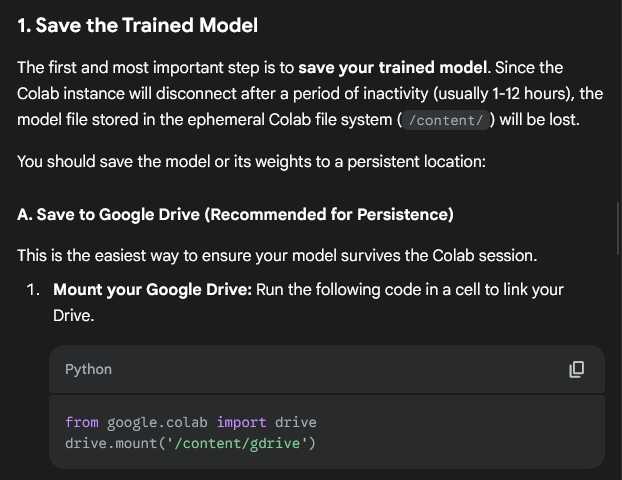

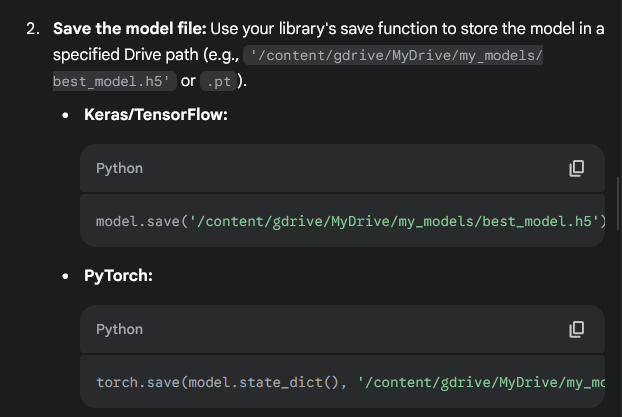

*   After finishing your work , make sure you do **CTRL + S** to save the document and then also commit the changes on the github by going to **File-> Save a copy in GITHUB**, log into your github and select our repo and then make sure the name of the **ipynb** file already matches what is already there in the repo **(DMML_GROUP_12.ipynb)** and put a commit message and save it there.

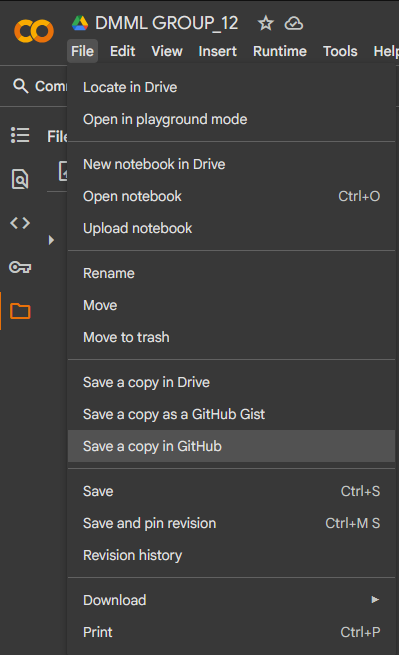



* A**BOVE EACH LAB, ADD YOUR DEPENDANCIES AND INSTALL THEM IF REQUIRED AS EACH TIME THE VM STOPS, THOSE DEPENDANCIES COULD GET DELETED AS WELL. (EG - pip install numpy, mathplotlib, etc) (IF REQUIRED)**

# **RUN THIS TO CONNECT TO THE DRIVE**


*   THIS HAS TO BE RUN TO CONNECT TO THE DRIVE EVERYTIME YOU START THE VM




In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Pre processing features in Ad_table - VIR**

Modified the Ad_table to remove the Ad_month and saved it as a new table called Adv_table. Decided to not use Basic_table, Sales_table, Trim_table for the training, as it is not required for our aim.

In [ ]:
import pandas as pd

file_path = '/content/drive/MyDrive/DMML DATA/tables_V2.0/Ad_table.csv'

df = pd.read_csv(file_path, low_memory=False)
df.head()

df = df.drop(['Adv_month'], axis=1)

df.to_csv('/content/drive/MyDrive/DMML DATA/tables_V2.0/Adv_table.csv', index=False)


# Lab 2 Dependancies

# Lab 2


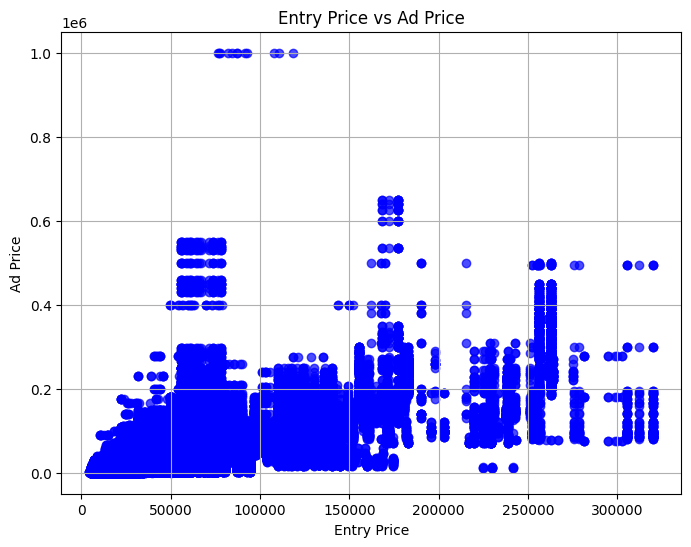

In [ ]:
import sys
assert sys.version_info >= (3,5)

import sklearn
assert sklearn.__version__ >= "0.20"

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

path_price_table = "/content/drive/MyDrive/DMML DATA/tables_V2.0/Price_table.csv"
path_ad_table = "/content/drive/MyDrive/DMML DATA/tables_V2.0/Adv_table.csv"

price_data = pd.read_csv(path_price_table, low_memory=False)
ad_data = pd.read_csv(path_ad_table, low_memory=False)

price_data.columns = price_data.columns.str.strip()
ad_data.columns = ad_data.columns.str.strip()

merged_data = pd.merge(price_data, ad_data, on='Genmodel_ID')

merged_data['Entry_price'] = pd.to_numeric(merged_data['Entry_price'], errors='coerce')
merged_data['Price'] = pd.to_numeric(merged_data['Price'], errors='coerce')

merged_data = merged_data.dropna(subset=['Entry_price', 'Price'])

entryPrice = merged_data['Entry_price']
ad_price = merged_data['Price']

plt.figure(figsize=(8,6))
plt.scatter(entryPrice, ad_price, alpha=0.7, color='blue')
plt.title('Entry Price vs Ad Price')
plt.xlabel('Entry Price')
plt.ylabel('Ad Price')
plt.grid(True)
plt.show()


# Lab 3 Dependancies

# Lab 3


# Tabular Data Preprocessing


In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer


ad_table_path = "/content/drive/MyDrive/DMML DATA/tables_V2.0/Adv_table.csv"
price_table_path = "/content/drive/MyDrive/DMML DATA/tables_V2.0/Price_table.csv"


df_ad = pd.read_csv(ad_table_path, low_memory=False)
df_price = pd.read_csv(price_table_path, low_memory=False)

df_ad.columns = df_ad.columns.str.strip()
df_price.columns = df_price.columns.str.strip()

#cleaning price to numeric values only
df_ad['Price'] = pd.to_numeric(df_ad['Price'], errors='coerce')

#merging tables on gen model ID and Year
merged_data = pd.merge(
    df_ad,
    df_price,
    left_on=['Genmodel_ID', 'Reg_year'],
    right_on=['Genmodel_ID', 'Year'],
    how='left',
    suffixes=('', '_price')
)

# Drop redundant columns: 'Year' and suffixed right-table cols
if 'Year' in merged_data.columns:
    merged_data = merged_data.drop(columns=['Year'])
merged_data = merged_data.drop(columns=['Maker_price', 'Genmodel_price'], errors='ignore')

#checking if merge worked
print("Merged data shape:", merged_data.shape)
print("Columns:", merged_data.columns.tolist())
print(merged_data.head())

#null counts
nan_entry = merged_data['Entry_price'].isnull().sum()
print(f"\nNumber of NaN Entry_price values: {nan_entry}")
print(f"Percentage unmatched: {(nan_entry / len(merged_data)) * 100:.2f}%")
print(f"Number of NaN Price values after cleaning: {merged_data['Price'].isnull().sum()}")

#handling nulls
merged_data = merged_data.dropna(subset=['Price'])
print(f"Rows after dropping NaN Price: {len(merged_data)}")

#test train split (80- 20) based on the counts of each 'Maker'
# Impute Entry_price: Median per Maker, then overall median
merged_data['Entry_price'] = merged_data.groupby('Maker')['Entry_price'].transform(
    lambda x: x.fillna(x.median())
)
overall_median = merged_data['Entry_price'].median()
merged_data['Entry_price'] = merged_data['Entry_price'].fillna(overall_median)

print(f"NaN Entry_price after imputation: {merged_data['Entry_price'].isnull().sum()}")
print(f"Final dataset shape: {merged_data.shape}")


merged_data['MSRP_Category'] = pd.qcut(
    merged_data['Entry_price'], # The continuous column to be categorized.
    q=3, # Divide the data into 3 quantiles (equal-sized bins).
    labels=['Low', 'Medium', 'High'], # Assign labels to the 3 bins.
    duplicates='drop' # Handle cases where quantile values are the same by dropping duplicate bins.
)

print(f"\nTarget MSRP category counts:\n{merged_data['MSRP_Category'].value_counts()}")

np.random.seed(42)
train_indices = []
test_indices = []

for maker, group in merged_data.groupby('Maker'):
    n_samples = len(group)
    if n_samples == 0:
        continue
    n_train = int(0.8 * n_samples)

    train_idx = group.sample(n=n_train, random_state=42).index
    train_indices.extend(train_idx)

    test_idx = group.drop(train_idx).index
    test_indices.extend(test_idx)

df_train = merged_data.loc[train_indices].reset_index(drop=True)
df_test = merged_data.loc[test_indices].reset_index(drop=True)

#verifying split
print(f"\nTrain set size: {len(df_train)} ({len(df_train)/len(merged_data)*100:.1f}%)")
print(f"Test set size: {len(df_test)} ({len(df_test)/len(merged_data)*100:.1f}%)")

print("\nTrain proportions by Maker (top 5):")
print(df_train['Maker'].value_counts(normalize=True).head())
print("\nTest proportions by Maker (top 5):")
print(df_test['Maker'].value_counts(normalize=True).head())

print("\n" + "="*50 + "\n")
print("Training Gaussian Naive Bayes Model")
print("="*50 + "\n")

#engine size conversion to numeric
def numeric_Engine_Size(df):
  df['Engin_size_L'] = pd.to_numeric(df['Engin_size'].str.replace('L', '', regex=False), errors='coerce')
  median_engine = df['Engin_size_L'].median()
  df['Engin_size_L'] = df['Engin_size_L'].fillna(median_engine)
  return df

df_train = numeric_Engine_Size(df_train)
df_test = numeric_Engine_Size(df_test)

X_train = df_train.drop(columns=['Entry_price', 'MSRP_Category', 'Engin_size'])
y_train = df_train['MSRP_Category']

X_test = df_test.drop(columns=['Entry_price', 'MSRP_Category', 'Engin_size'])
y_test = df_test['MSRP_Category']


numerical_features = ['Runned_Miles', 'Price', 'Reg_year', 'Engin_size_L']
non_numerical_features = ['Maker', 'Bodytype', 'Gearbox', 'Fuel_type', 'Color']

numericalTransformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

nonNumericalTransformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numericalTransformer, numerical_features),
        ('non_num', nonNumericalTransformer, non_numerical_features)
    ],
    remainder='drop'
    )

label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', GaussianNB())
])

print("training started")
model.fit(X_train, y_train_encoded)
print("training complete")

y_prediction_encoded = model.predict(X_test)
y_predict = label_encoder.inverse_transform(y_prediction_encoded)
y_prediction = label_encoder.inverse_transform(y_prediction_encoded)

accuracy = accuracy_score(y_test, y_prediction)
print(f"Accuracy: {accuracy:.2f}")


Merged data shape: (268255, 16)
Columns: ['Maker', 'Genmodel', 'Genmodel_ID', 'Adv_ID', 'Adv_year', 'Color', 'Reg_year', 'Bodytype', 'Runned_Miles', 'Engin_size', 'Gearbox', 'Fuel_type', 'Price', 'Seat_num', 'Door_num', 'Entry_price']
     Maker Genmodel Genmodel_ID   Adv_ID  Adv_year   Color  Reg_year Bodytype  \
0  Bentley   Arnage        10_1  10_1$$1      2018  Silver    2000.0   Saloon   
1  Bentley   Arnage        10_1  10_1$$2      2018    Grey    2002.0   Saloon   
2  Bentley   Arnage        10_1  10_1$$3      2017    Blue    2002.0   Saloon   
3  Bentley   Arnage        10_1  10_1$$4      2018   Green    2003.0   Saloon   
4  Bentley   Arnage        10_1  10_1$$5      2017    Grey    2003.0   Saloon   

  Runned_Miles Engin_size    Gearbox Fuel_type    Price  Seat_num  Door_num  \
0        60000       6.8L  Automatic    Petrol  21500.0       5.0       4.0   
1        44000       6.8L  Automatic    Petrol  28750.0       5.0       4.0   
2        55000       6.8L  Automatic    P

ValueError: could not convert string to float: '1 mile'

# Trained CNN on Image data

In [ ]:
# rq2_image_classification.py
# RQ2: Image classification for body type & manufacturer using DVM-CAR resized images
# Approaches:
#   1) Transfer learning with a pre-trained CNN (single task: bodytype OR manufacturer, softmax outputs)
#   2) Multi-task with two softmax heads (bodytype AND manufacturer, softmax outputs)
#
# USAGE EXAMPLES:
#   python rq2_image_classification.py --approach single --single_target bodytype
#   python rq2_image_classification.py --approach single --single_target manufacturer
#   python rq2_image_classification.py --approach multitask
#
# ---- SETUP ----
# 1) pip install -U torch torchvision pandas numpy scikit-learn Pillow matplotlib seaborn
# 2) Edit the Config paths below to your CSVs and image root
# 3) We assume: using the full resized DVM (not the quality-checked subset).
#    We do NOT filter by quality; we keep all angles (Predicted_viewpoint) and avoid leakage by Adv_ID grouping.

from pathlib import Path
import json
import random
import argparse
from dataclasses import dataclass, asdict
from typing import List, Dict

import pandas as pd
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from PIL import Image

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GroupShuffleSplit
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report

import matplotlib.pyplot as plt
import seaborn as sns

import torchvision.transforms as T
from torchvision.models import resnet50, ResNet50_Weights


# =========================
# CONFIG: EDIT THESE PATHS
# =========================
@dataclass
class Config:
    # Paths
    dataset_root: str = "/path/to/DVM_images_root"     # folder with 300x300 JPGs; image paths are relative to this
    ad_csv: str = "/path/to/Ad_table.csv"
    image_csv: str = "/path/to/Image_table.csv"
    basic_csv: str = "/path/to/Basic_table.csv"

    # Column names
    col_adv_id: str = "Adv_ID"
    col_genmodel_id: str = "Genmodel_ID"
    col_image_name: str = "Image_name"
    col_pred_view: str = "Predicted_viewpoint"
    col_quality: str = "quality_check"
    col_bodytype: str = "Bodytype"                     # label for task 1
    col_automaker_basic: str = "Automaker"             # label for task 2 (via Basic table)

    # Training
    seed: int = 42
    num_workers: int = 4
    batch_size: int = 64
    epochs: int = 10
    lr: float = 1e-3
    weight_decay: float = 1e-4
    freeze_backbone: bool = True                       # classic transfer learning; set False to fine-tune

    # Split (grouped by Adv_ID to avoid leakage)
    train_size: float = 0.8
    val_size_of_rest: float = 0.5                      # 50% of remainder to val; rest to test

    # Images
    image_size: int = 224
    use_mixed_precision: bool = True

    device: str = "cuda" if torch.cuda.is_available() else "cpu"
    out_dir: str = "./rq2_outputs"
    approach: str = "single"                           # "single" or "multitask"
    single_task_target: str = "bodytype"               # used when approach=="single"


def set_seed(seed: int):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)


# =========================
# Data loading & joins
# =========================
def load_and_join(cfg: Config) -> pd.DataFrame:
    """Join Image↔Ad↔Basic to get image_path, Bodytype, Automaker, Adv_ID, Predicted_viewpoint."""
    ad = pd.read_csv(cfg.ad_csv)
    img = pd.read_csv(cfg.image_csv)
    basic = pd.read_csv(cfg.basic_csv)

    ad = ad[[cfg.col_adv_id, cfg.col_genmodel_id, cfg.col_bodytype]]
    img = img[[cfg.col_adv_id, cfg.col_genmodel_id, cfg.col_image_name, cfg.col_pred_view, cfg.col_quality]]
    basic = basic[[cfg.col_genmodel_id, cfg.col_automaker_basic]].drop_duplicates(cfg.col_genmodel_id)

    df = img.merge(ad, on=[cfg.col_adv_id, cfg.col_genmodel_id], how="inner")
    df = df.merge(basic, on=cfg.col_genmodel_id, how="left")

    # build full path to the image on disk
    root = Path(cfg.dataset_root)
    df["image_path"] = df[cfg.col_image_name].astype(str).apply(lambda p: str(root / p))

    # drop rows missing labels or path
    df = df.dropna(subset=[cfg.col_bodytype, cfg.col_automaker_basic, "image_path"]).reset_index(drop=True)
    return df


# =========================
# Dataset
# =========================
class DVMImageDataset(Dataset):
    def __init__(self, df: pd.DataFrame, body_enc: LabelEncoder, maker_enc: LabelEncoder,
                 cfg: Config, split: str = "train"):
        self.df = df.reset_index(drop=True)
        self.cfg = cfg
        self.body_enc = body_enc
        self.maker_enc = maker_enc
        self.split = split

        if split == "train":
            self.transform = T.Compose([
                T.Resize(int(cfg.image_size * 1.15)),
                T.RandomResizedCrop(cfg.image_size, scale=(0.8, 1.0)),
                T.RandomHorizontalFlip(),
                T.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
                T.ToTensor(),
                T.Normalize(mean=ResNet50_Weights.IMAGENET1K_V2.meta["mean"],
                            std=ResNet50_Weights.IMAGENET1K_V2.meta["std"]),
            ])
        else:
            self.transform = T.Compose([
                T.Resize(cfg.image_size + 32),
                T.CenterCrop(cfg.image_size),
                T.ToTensor(),
                T.Normalize(mean=ResNet50_Weights.IMAGENET1K_V2.meta["mean"],
                            std=ResNet50_Weights.IMAGENET1K_V2.meta["std"]),
            ])

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img = Image.open(row["image_path"]).convert("RGB")
        x = self.transform(img)

        y_body = int(self.body_enc.transform([row[self.cfg.col_bodytype]])[0])
        y_maker = int(self.maker_enc.transform([row[self.cfg.col_automaker_basic]])[0])

        adv_id = row[self.cfg.col_adv_id]
        viewpoint = row[self.cfg.col_pred_view]
        return x, y_body, y_maker, adv_id, viewpoint


# =========================
# Models
# =========================
class SingleHeadResNet(nn.Module):
    """Single-task transfer learning: ResNet50 + Linear head -> logits (softmax in CE)."""
    def __init__(self, num_classes: int, freeze_backbone: bool = True):
        super().__init__()
        self.backbone = resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)
        if freeze_backbone:
            for p in self.backbone.parameters():
                p.requires_grad = False
        in_feats = self.backbone.fc.in_features
        self.backbone.fc = nn.Linear(in_feats, num_classes)  # logits for CrossEntropy (softmax applied internally)

    def forward(self, x):
        return self.backbone(x)


class MultiHeadResNet(nn.Module):
    """Multi-task: shared ResNet50 backbone, two heads (bodytype & manufacturer), each softmaxed by CE."""
    def __init__(self, num_bodytypes: int, num_makers: int, freeze_backbone: bool = True):
        super().__init__()
        self.backbone = resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)
        if freeze_backbone:
            for p in self.backbone.parameters():
                p.requires_grad = False
        in_feats = self.backbone.fc.in_features
        self.backbone.fc = nn.Identity()
        self.head_body = nn.Linear(in_feats, num_bodytypes)  # logits
        self.head_maker = nn.Linear(in_feats, num_makers)    # logits

    def forward(self, x):
        feats = self.backbone(x)
        return self.head_body(feats), self.head_maker(feats)


# =========================
# Metrics & helpers
# =========================
def compute_metrics(y_true, y_pred) -> Dict[str, float]:
    return {
        "accuracy": accuracy_score(y_true, y_pred),
        "f1_macro": f1_score(y_true, y_pred, average="macro"),
        "f1_weighted": f1_score(y_true, y_pred, average="weighted"),
    }

def plot_confmat(cm: np.ndarray, classes: List[str], title: str, out_path: Path):
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=False, fmt="d", xticklabels=classes, yticklabels=classes)
    plt.title(title)
    plt.ylabel("True")
    plt.xlabel("Predicted")
    plt.tight_layout()
    out_path.parent.mkdir(parents=True, exist_ok=True)
    plt.savefig(out_path)
    plt.close()

def save_json(obj, path: Path):
    path.parent.mkdir(parents=True, exist_ok=True)
    with open(path, "w") as f:
        json.dump(obj, f, indent=2)


# =========================
# Train/Eval (single-task)
# =========================
def train_single(cfg: Config, df_train, df_val, df_test, body_enc, maker_enc):
    target = cfg.single_task_target
    classes = list(body_enc.classes_) if target == "bodytype" else list(maker_enc.classes_)
    num_classes = len(classes)

    model = SingleHeadResNet(num_classes=num_classes, freeze_backbone=cfg.freeze_backbone).to(cfg.device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=cfg.lr, weight_decay=cfg.weight_decay)
    scaler = torch.cuda.amp.GradScaler(enabled=cfg.use_mixed_precision)

    def mk_loader(df, split):
        ds = DVMImageDataset(df, body_enc, maker_enc, cfg, split=split)
        return DataLoader(ds, batch_size=cfg.batch_size, shuffle=(split=="train"),
                          num_workers=cfg.num_workers, pin_memory=True)

    train_loader = mk_loader(df_train, "train")
    val_loader   = mk_loader(df_val,   "val")
    test_loader  = mk_loader(df_test,  "test")

    history = {"train_loss": [], "val_loss": [], "val_acc": [], "val_f1_macro": []}

    for epoch in range(cfg.epochs):
        model.train()
        total_loss = 0.0
        for xb, yb, ym, _, _ in train_loader:
            xb = xb.to(cfg.device, non_blocking=True)
            y  = (yb if target == "bodytype" else ym).to(cfg.device, non_blocking=True)
            optimizer.zero_grad(set_to_none=True)
            with torch.cuda.amp.autocast(enabled=cfg.use_mixed_precision):
                logits = model(xb)
                loss = criterion(logits, y)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            total_loss += loss.item() * xb.size(0)

        # validate
        model.eval()
        val_loss, y_true, y_pred = 0.0, [], []
        with torch.no_grad():
            for xb, yb, ym, _, _ in val_loader:
                xb = xb.to(cfg.device, non_blocking=True)
                y  = (yb if target == "bodytype" else ym).to(cfg.device, non_blocking=True)
                with torch.cuda.amp.autocast(enabled=cfg.use_mixed_precision):
                    logits = model(xb)
                    loss = criterion(logits, y)
                val_loss += loss.item() * xb.size(0)
                pred = torch.argmax(logits, dim=1).cpu().numpy().tolist()
                y_true += y.cpu().numpy().tolist()
                y_pred += pred

        metrics = compute_metrics(y_true, y_pred)
        history["train_loss"].append(total_loss / len(train_loader.dataset))
        history["val_loss"].append(val_loss / len(val_loader.dataset))
        history["val_acc"].append(metrics["accuracy"])
        history["val_f1_macro"].append(metrics["f1_macro"])
        print(f"[{epoch+1}/{cfg.epochs}] train_loss={history['train_loss'][-1]:.4f} "
              f"val_loss={history['val_loss'][-1]:.4f} val_acc={metrics['accuracy']:.4f} "
              f"val_f1_macro={metrics['f1_macro']:.4f}")

    # test
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for xb, yb, ym, _, _ in test_loader:
            xb = xb.to(cfg.device, non_blocking=True)
            y  = (yb if target == "bodytype" else ym).to(cfg.device, non_blocking=True)
            logits = model(xb)
            y_true += y.cpu().numpy().tolist()
            y_pred += torch.argmax(logits, dim=1).cpu().numpy().tolist()

    test_metrics = compute_metrics(y_true, y_pred)
    print("TEST:", test_metrics)

    out_dir = Path(cfg.out_dir) / f"single_{target}"
    out_dir.mkdir(parents=True, exist_ok=True)

    # confusion matrix & report
    cm = confusion_matrix(y_true, y_pred)
    plot_confmat(cm, classes, f"Confusion Matrix ({target})", out_dir / "confusion_matrix.png")
    report = classification_report(y_true, y_pred, target_names=classes, digits=3)
    (out_dir / "classification_report.txt").write_text(report)

    save_json({"history": history, "test_metrics": test_metrics, "config": asdict(cfg)}, out_dir / "results.json")
    torch.save(model.state_dict(), out_dir / "model.pt")


# =========================
# Train/Eval (multi-task)
# =========================
def train_multitask(cfg: Config, df_train, df_val, df_test, body_enc, maker_enc):
    num_body = len(body_enc.classes_)
    num_maker = len(maker_enc.classes_)
    model = MultiHeadResNet(num_body, num_maker, freeze_backbone=cfg.freeze_backbone).to(cfg.device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=cfg.lr, weight_decay=cfg.weight_decay)
    scaler = torch.cuda.amp.GradScaler(enabled=cfg.use_mixed_precision)

    def mk_loader(df, split):
        ds = DVMImageDataset(df, body_enc, maker_enc, cfg, split=split)
        return DataLoader(ds, batch_size=cfg.batch_size, shuffle=(split=="train"),
                          num_workers=cfg.num_workers, pin_memory=True)

    train_loader = mk_loader(df_train, "train")
    val_loader   = mk_loader(df_val,   "val")
    test_loader  = mk_loader(df_test,  "test")

    history = {"train_loss": [], "val_loss": [], "val_acc_body": [], "val_f1_body": [],
               "val_acc_maker": [], "val_f1_maker": []}

    for epoch in range(cfg.epochs):
        model.train()
        total_loss = 0.0
        for xb, yb, ym, _, _ in train_loader:
            xb, yb, ym = xb.to(cfg.device, non_blocking=True), yb.to(cfg.device, non_blocking=True), ym.to(cfg.device, non_blocking=True)
            optimizer.zero_grad(set_to_none=True)
            with torch.cuda.amp.autocast(enabled=cfg.use_mixed_precision):
                logits_b, logits_m = model(xb)
                loss = criterion(logits_b, yb) + criterion(logits_m, ym)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            total_loss += loss.item() * xb.size(0)

        # validate
        model.eval()
        val_loss, yb_true, yb_pred, ym_true, ym_pred = 0.0, [], [], [], []
        with torch.no_grad():
            for xb, yb, ym, _, _ in val_loader:
                xb, yb, ym = xb.to(cfg.device, non_blocking=True), yb.to(cfg.device, non_blocking=True), ym.to(cfg.device, non_blocking=True)
                with torch.cuda.amp.autocast(enabled=cfg.use_mixed_precision):
                    logits_b, logits_m = model(xb)
                    loss = criterion(logits_b, yb) + criterion(logits_m, ym)
                val_loss += loss.item() * xb.size(0)
                yb_true += yb.cpu().numpy().tolist()
                ym_true += ym.cpu().numpy().tolist()
                yb_pred += torch.argmax(logits_b, dim=1).cpu().numpy().tolist()
                ym_pred += torch.argmax(logits_m, dim=1).cpu().numpy().tolist()

        mb = compute_metrics(yb_true, yb_pred)
        mm = compute_metrics(ym_true, ym_pred)
        history["train_loss"].append(total_loss / len(train_loader.dataset))
        history["val_loss"].append(val_loss / len(val_loader.dataset))
        history["val_acc_body"].append(mb["accuracy"]); history["val_f1_body"].append(mb["f1_macro"])
        history["val_acc_maker"].append(mm["accuracy"]); history["val_f1_maker"].append(mm["f1_macro"])
        print(f"[{epoch+1}/{cfg.epochs}] train_loss={history['train_loss'][-1]:.4f} "
              f"val_loss={history['val_loss'][-1]:.4f} "
              f"body_acc={mb['accuracy']:.4f} body_f1={mb['f1_macro']:.4f} "
              f"maker_acc={mm['accuracy']:.4f} maker_f1={mm['f1_macro']:.4f}")

    # test
    model.eval()
    yb_true, yb_pred, ym_true, ym_pred = [], [], [], []
    with torch.no_grad():
        for xb, yb, ym, _, _ in test_loader:
            xb, yb, ym = xb.to(cfg.device, non_blocking=True), yb.to(cfg.device, non_blocking=True), ym.to(cfg.device, non_blocking=True)
            logits_b, logits_m = model(xb)
            yb_pred += torch.argmax(logits_b, dim=1).cpu().numpy().tolist()
            ym_pred += torch.argmax(logits_m, dim=1).cpu().numpy().tolist()
            yb_true += yb.cpu().numpy().tolist()
            ym_true += ym.cpu().numpy().tolist()

    out_dir = Path(cfg.out_dir) / "multitask"
    out_dir.mkdir(parents=True, exist_ok=True)

    mb = compute_metrics(yb_true, yb_pred)
    mm = compute_metrics(ym_true, ym_pred)
    print("TEST bodytype:", mb)
    print("TEST manufacturer:", mm)

    classes_body = list(body_enc.classes_)
    classes_maker = list(maker_enc.classes_)
    cm_b = confusion_matrix(yb_true, yb_pred)
    cm_m = confusion_matrix(ym_true, ym_pred)
    plot_confmat(cm_b, classes_body, "Confusion Matrix (Bodytype)", out_dir / "confmat_bodytype.png")
    plot_confmat(cm_m, classes_maker, "Confusion Matrix (Manufacturer)", out_dir / "confmat_maker.png")

    (out_dir / "classification_report_bodytype.txt").write_text(
        classification_report(yb_true, yb_pred, target_names=classes_body, digits=3)
    )
    (out_dir / "classification_report_maker.txt").write_text(
        classification_report(ym_true, ym_pred, target_names=classes_maker, digits=3)
    )

    save_json({"history": history, "test_metrics_bodytype": mb, "test_metrics_manufacturer": mm,
               "config": asdict(cfg)}, out_dir / "results.json")
    torch.save(model.state_dict(), out_dir / "model.pt")


# =========================
# Grouped split (leak-safe)
# =========================
def group_train_val_test_split(df: pd.DataFrame, group_col: str, train_size: float, val_size_of_rest: float, seed: int):
    """Keep all images from the same advert (Adv_ID) in the same split."""
    groups = df[group_col].values
    gss = GroupShuffleSplit(n_splits=1, train_size=train_size, random_state=seed)
    train_idx, rest_idx = next(gss.split(df, groups=groups))
    df_train = df.iloc[train_idx].copy()
    df_rest = df.iloc[rest_idx].copy()

    groups_rest = df_rest[group_col].values
    gss2 = GroupShuffleSplit(n_splits=1, train_size=val_size_of_rest, random_state=seed+1)
    val_idx, test_idx = next(gss2.split(df_rest, groups=groups_rest))
    df_val = df_rest.iloc[val_idx].copy()
    df_test = df_rest.iloc[test_idx].copy()
    return df_train.reset_index(drop=True), df_val.reset_index(drop=True), df_test.reset_index(drop=True)


# =========================
# Main
# =========================
def main():
    parser = argparse.ArgumentParser()
    parser.add_argument("--approach", choices=["single", "multitask"], default="single")
    parser.add_argument("--single_target", choices=["bodytype", "manufacturer"], default="bodytype")
    parser.add_argument("--config_json", type=str, default=None, help="optional JSON to override Config fields")
    args = parser.parse_args()

    cfg = Config()
    if args.config_json:
        with open(args.config_json) as f:
            override = json.load(f)
        for k, v in override.items():
            setattr(cfg, k, v)
    cfg.approach = args.approach
    cfg.single_task_target = args.single_target

    set_seed(cfg.seed)
    Path(cfg.out_dir).mkdir(parents=True, exist_ok=True)

    print("Loading & joining CSVs…")
    df = load_and_join(cfg)
    print(f"Rows after join: {len(df)}")

    # Encode labels
    body_enc = LabelEncoder().fit(df[cfg.col_bodytype])
    maker_enc = LabelEncoder().fit(df[cfg.col_automaker_basic])

    # Save classes
    lab_dir = Path(cfg.out_dir) / "labels"
    lab_dir.mkdir(parents=True, exist_ok=True)
    (lab_dir / "classes.json").write_text(json.dumps({
        "bodytype_classes": list(body_enc.classes_),
        "manufacturer_classes": list(maker_enc.classes_)
    }, indent=2))

    # Grouped split by Adv_ID
    print("Grouped split by Adv_ID (leak-safe)…")
    df_train, df_val, df_test = group_train_val_test_split(
        df, cfg.col_adv_id, cfg.train_size, cfg.val_size_of_rest, cfg.seed
    )
    print(f"Train: {len(df_train)} | Val: {len(df_val)} | Test: {len(df_test)}")

    # Train
    if cfg.approach == "single":
        print(f"Training SINGLE-TASK model ({cfg.single_task_target})")
        train_single(cfg, df_train, df_val, df_test, body_enc, maker_enc)
    else:
        print("Training MULTI-TASK model (bodytype + manufacturer)")
        train_multitask(cfg, df_train, df_val, df_test, body_enc, maker_enc)


if __name__ == "__main__":
    main()


KeyboardInterrupt: 